# Programming Exercise 7: K-means Clustering and Principal Component Analysis

## Introduction

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images. 


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn import svm

## 1. K-means Clustering

In this exercise, you will implement the K-means algorithm and use it for image compression. You will first start on an example 2D dataset. After that, you will use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are the most common in that image.

### 1.1 Implementing K-means

The inner loop of the algorithm repeatedly carries out two steps: 
1. assign each training example to its closest centroid, and
2. recompute the mean of each centroid using the points assigned to it.

We will implement the two phases of the K-means algorithm separately.


In [11]:
# load sample data:
datamat = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex7/ex7/ex7data2.mat')

X = datamat['X']
X.shape

(300, 2)

#### 1.1.1 Finding closest centroids
Given the current position of centroids, assign every training example to its closest centroid. 

In [120]:
import math

def findClosestCentroids(X, centroids):
    K = len(centroids)   # assuming centroids is just a list of positions
    idx = []             # return a list of the closest centroids
    for i in X:
        mindist = 1000000
        index = 0
        for j in range(K):

            dist = math.hypot(i[0] - centroids[j][0], i[1] - centroids[j][1])
            dist_squared = dist**2

            if (dist_squared < mindist):
                mindist = dist_squared
                index = j
        idx.append(index)
    return np.array(idx)


In [121]:
# the closest centroids for the first 3 examples should be [1, 3, 2]
# our indexes are off by one 
K = 3
initial_cents = np.array([[3,3],[6,2],[8,5]])
indexes = findClosestCentroids(X, initial_cents)
indexes[0:3]

array([0, 2, 1])

### 1.1.2 Computing centroid means

For each centorid, compute the mean of the points that were assigned to it.

In [122]:
def computeCentroids(X, indexes, K):
    m, n = X.shape[0], X.shape[1]
    centroids = np.zeros((K,n))
    for i in range(K):
        applicable = (indexes == i)*1
        for j in range(n):
            centroids[i,j] = np.sum(np.dot(X[:,j],applicable)) / sum(applicable)
    return centroids

In [124]:
# centroids computed after initial finding of closest centroids should be:
#   [ 2.428301 3.157924 ]
#   [ 5.813503 2.633656 ]
#   [ 7.119387 3.616684 ]

computeCentroids(X, indexes, 3)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

### 1.2 K-means on example dataset



In [180]:
def runKmeans(X, initial_centroids, max_iters, plot_progress):

    # initialize values
    m, n = X.shape[0], X.shape[1]
    K = len(initial_centroids)  
    centroids = initial_centroids
    previous_centroids = centroids
    idx = []
    
    # run K-means
    for i in range(max_iters):
        print 'K-Means iteration #', i
        
        # for each example in X, assign it to the closest centroid
        idx = findClosestCentroids(X, centroids)
        
        # plot progress here (if plot_progress = True)
        if plot_progress:
            plotProgresskMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
        
        # given the memberships, compute new centroids
        centroids = computeCentroids(X, idx, K)
        
    return centroids, idx


In [181]:
def plotProgresskMeans(X, centroids, previous, idx, K, i):
    # plot the examples
    plotDataPoints(X, idx, K)
    
    # plot the centroids as black x's
    plt.scatter(centroids[:,0], centroids[:,1], marker = 'x', c = 'black', s = 100)
    
    # plot the history of the centroids with lines
    for j in range(len(centroids)):
        drawLine(centroids[j, :], previous[j, :])
    title = 'Iteration number ' + str(i)
    plt.title(title)    
    return 

In [182]:
def plotDataPoints(X, idx, K):
    palette = ['red', 'green', 'blue']
    colors = []
    for i in idx:
        colors.append(palette[i])
    plt.scatter(X[:,0], X[:,1], 15, colors)
    return

In [184]:
def drawLine(p1, p2):
    # draws a line from p1 to p2
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    return

K-Means iteration # 0
K-Means iteration # 1
K-Means iteration # 2
K-Means iteration # 3
K-Means iteration # 4
K-Means iteration # 5
K-Means iteration # 6
K-Means iteration # 7
K-Means iteration # 8
K-Means iteration # 9


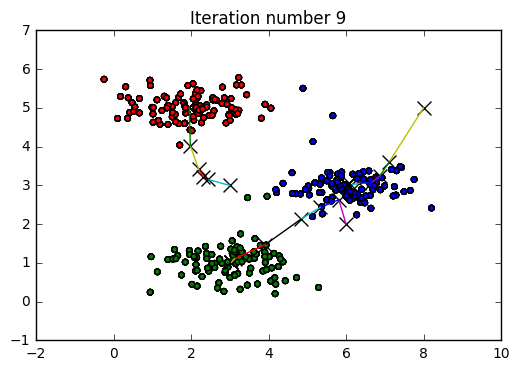

In [188]:
# Run K-Means cluster on example dataset

K = 3
max_iters = 10
initial_cents = np.array([[3,3],[6,2],[8,5]])

cents, idx = runKmeans(X, initial_cents, max_iters, True)

### 1.3 Random Initialization

The initial assignment of centroids was designed so that we would see the same figure as shown in the PDF documentation. In practice, a good strategy for initializing the centroids to select random examples from the training set.

In [232]:
def kMeansInitCentroids(X, K):
    centroids = []
    lis = []
    for i in range(len(X)):
        lis.append(i)
        
    randoms = np.random.choice(lis, K, replace = False)
    centroids = np.array([X[i] for i in randoms]) 
    return centroids
rand_cents = kMeansInitCentroids(X, 3)

### 1.4 Image compression with K-means

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely,  you will treat every pixel in the original image as a data example, and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3 dimensional RGB space.

#### 1.4.1 K-means on pixels

We can read images in as an array of pixels using scipy's imread.
This creates a three-dimensional matrix A whose first two indices identify a pixel position, and whose last index represents red, green, or blue.

For example, A(50, 33, 3) gives the blue intensity of the pixel at row 50 and column 33.

In [237]:
from scipy.misc import imread

A = imread('/Users/tess/Desktop/MachineLearning/machine-learning-ex7/ex7/bird_small.png')
A.shape

(128, 128, 3)

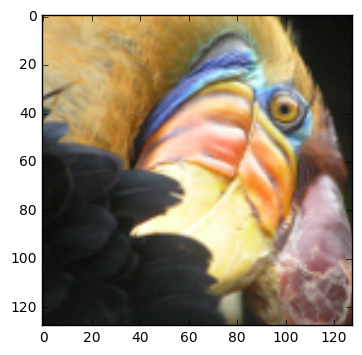

In [238]:
image = plt.imshow(A)

In [234]:
# reshape matrix A into an m x 3 matrix where m = 16384 = 128 x 128

A = A/255. # divide by 255 so that all values are in range 0 - 1
img_size = A.shape

# reshape:
Ximage = np.reshape(A, (img_size[0] * img_size[1], 3))
Ximage.shape

(16384, 3)

In [245]:
# run K-means algorithm on this data
K = 16
max_iters = 10
initial_cents_image = kMeansInitCentroids(Ximage, K)
initial_cents_image
cents_image, idx_image = runKmeans(Ximage, initial_cents_image, max_iters, False)

K-Means iteration # 0
K-Means iteration # 1
K-Means iteration # 2
K-Means iteration # 3
K-Means iteration # 4
K-Means iteration # 5
K-Means iteration # 6
K-Means iteration # 7
K-Means iteration # 8
K-Means iteration # 9


In [249]:
# Image Compression.
# First, find closest cluster members:
index = findClosestCentroids(Ximage, cents_image)

# essentially, now we have represented the image X in terms of the indices in index
# we can now recover the image from the indices by mapping each pixel to the centroid value
X_recovered = cents_image[index, :]

# reshape the recovered image into proper dimensions
X_recovered = np.reshape(X_recovered, (img_size[0], img_size[1], 3))

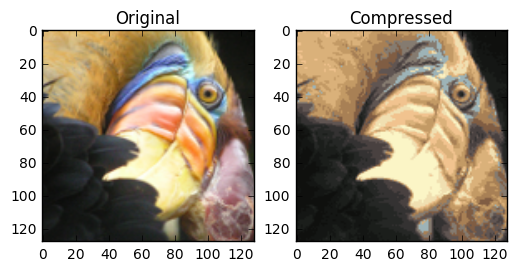

In [259]:
# display the original image in comparison to the compressed:
plt.subplot(1,2,1)
plt.imshow(A)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(X_recovered)
plt.title('Compressed')

## 2. Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction.

### 2.1 Example Dataset
To start, you will first work with a 2D dataset which has one direction of large variation and one of smaller variation.

In [260]:
# load sample data:
datapca = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex7/ex7/ex7data1.mat')

Xpca = datapca['X']
Xpca.shape

(50, 2)

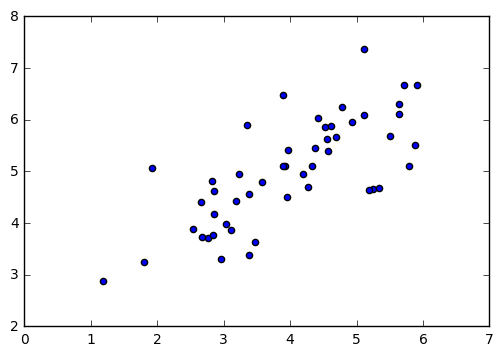

In [351]:
# visualize the example dataset:
def plotPCA(X):
    plt.scatter(X[:,0], X[:,1], marker = 'o', c = 'blue')
    #plt.xlim(0.5, 6.5)
    #plt.ylim(2, 8)
    return
plotPCA(Xpca)

### 2.2 Implementing PCA

In [273]:
# Before running PCA, it is important to normalize X

def featureNorm(X):
    
    normX = X
    means = np.mean(normX,axis=0) #column-by-column
    normX = normX - means
    stds = np.std(normX,axis=0,ddof=1)
    normX = normX / stds
    
    return normX, means, stds

X_norm, mu, sigma = featureNorm(Xpca)

In [284]:
def pca(X):
    m = X.shape[0]
    n = X.shape[1]
    
    U = np.zeros(n)
    S = np.zeros(n)

    sigma = (1./m)*np.dot(X.T, X)
    U, S, V = np.linalg.svd(sigma, full_matrices=True)

    return U, S

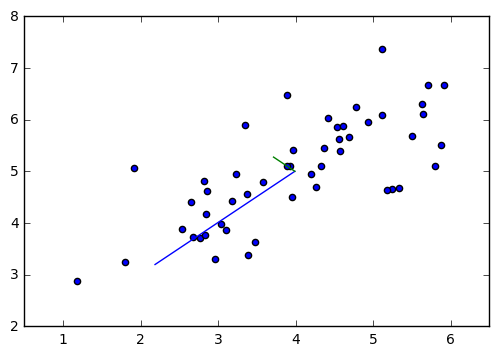

In [316]:
# Run PCA
[U, S] = pca(X_norm)
plotPCA(Xpca)

# Draw the eigenvectors centered at the mean of the data
# these lines show the directions of maximum variations in the dataset
drawLine(mu, [mu[0] +1.5*S[0]*U[0,0], mu[1]+ 1.5*S[0]*U[0,1]])
drawLine(mu, [mu[0] +1.5*S[1]*U[1,0], mu[1] +1.5*S[1]*U[1,1]])


In [317]:
# you should expected to see -0.707107 -0.707107 
print 'Top eigenvector: ', U[0]

Top eigenvector:  [-0.70710678 -0.70710678]


### 2.3 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space: x(i) --> z(i).

#### 2.3.1 Projecting the data onto the principal components


In [335]:
def projectData(X, U, K):
    Ureduce = U[:, 0:K]
    Z = np.dot(X, Ureduce)
    return Z

In [337]:
# project the first example onto the first dimension.
# you should see a value of about 1.481 (or -1.481)

projectedX = projectData(X_norm, U, 1)
projectedX[0]

array([ 1.48127391])

#### 2.3.2 Reconstructing an approximation of the data

After projecting the data, you can approximately recover the data by projecting them back onto the original high dimensional space

In [338]:
def recoverData(Z, U, K):
    Ureduce = U[:,0:K]
    X_rec = np.dot(Z, Ureduce.T)
    return X_rec

In [354]:
# approximation of the first example
# this value should be about -1.047419 -1.047419

recoveredX = recoverData(projectedX, U, 1)
recoveredX[0] 

array([-1.04741883, -1.04741883])

#### 2.3.3 Visualizing the projections

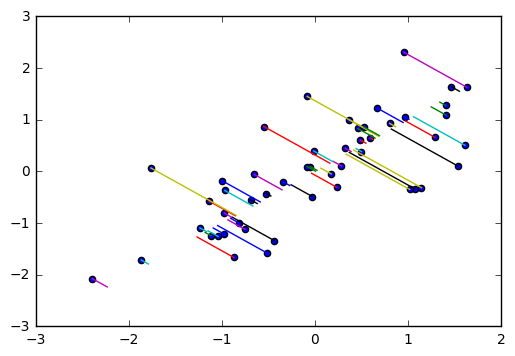

In [353]:
# draw lines connecting the projected points to the original points
plotPCA(X_norm)
for i in range(len(X_norm)):
    drawLine(X_norm[i, :], recoveredX[i,:])

### 2.4 Face Image Dataset

In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset contains a matrix X or face images, each 32 x 32 in grayscale. Each row of X corresponds to one face image (a row vector of length 1024). 

In [355]:
# load face data:
facedata = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex7/ex7/ex7faces.mat')

Xfaces = facedata['X']
Xfaces.shape

(5000, 1024)

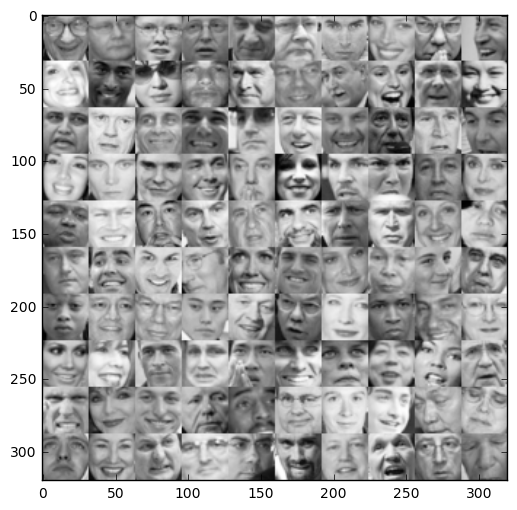

In [375]:
# randomly pick 100 rows from X and display in a 10 x 10 grid
from math import sqrt 
from math import floor, ceil
import matplotlib.cm as cm 

def DisplayData(X):
    # create random set of 100 training images
    #rand = X[np.random.randint(X.shape[0], size=100), :]
    
    # size of each image
    example_width, example_height = 32, 32
    # number of images in large array
    display_rows, display_cols = 10, 10
    # setup blank display
    display_array = np.zeros((example_height*display_rows, example_width*display_cols))
    
    row, col = 0, 0
    for image in range(100):
        if col == display_cols:
            row +=1
            col = 0
        squareimg = X[image].reshape(32,32).T
        display_array[row*example_height:row*example_height+squareimg.shape[0], col*example_width:col*example_width + squareimg.shape[1]] = squareimg
        col += 1

    fig = plt.figure(figsize = (6,6))
    img = scipy.misc.toimage(display_array)
    plt.imshow(img, cmap = cm.Greys_r)

a = DisplayData(Xfaces)

#### 2.4.1 PCA on Faces

First, we will normalize the dataset by subtracting the mean of each feature from the data matrix X. Then, we will run PCA. 

In [361]:
Xfaces_norm, faces_mu, faces_sigma = featureNorm(Xfaces)
[Ufaces, Sfaces] = pca(Xfaces_norm)

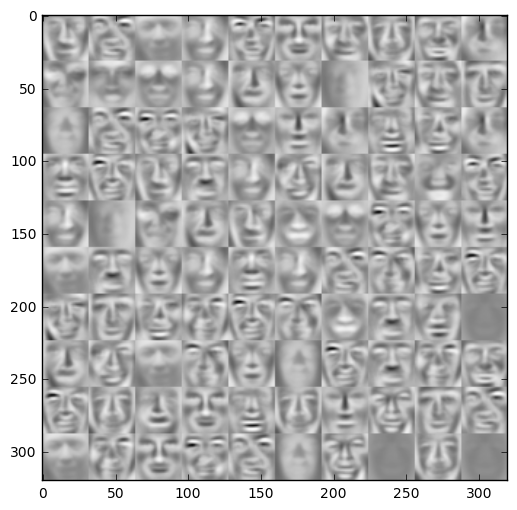

In [374]:
# visualize the top 36 eignevectors found
DisplayData(Ufaces[:, 0:36].T)

#### 2.4.2 Dimensionality Reduction

We can now use the principal components of the face dataset to reduce the dimension of the dataset. This would allow us to use our learning algorithm with a small input size (e.g. 100 dimensions) instead of the original 1024 dimension. This can help speed up the learning algorithm.

In [365]:
# project face dataset onto only the first 100 PCs
# each face image should now be described by a vector z(i) = 1 x 100
Xfaces_projected = projectData(Xfaces_norm, Ufaces, 100)
Xfaces_projected.shape

(5000, 100)

In [367]:
# to understand what is lost, try recovering the original face images
Xfaces_recovered = recoverData(Xfaces_projected, Ufaces, 100)
Xfaces_recovered.shape

(5000, 1024)

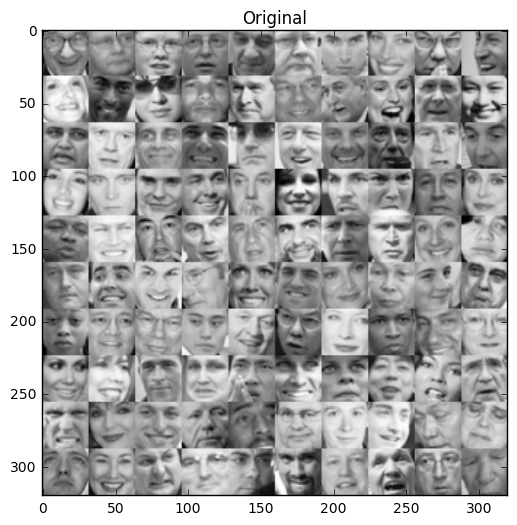

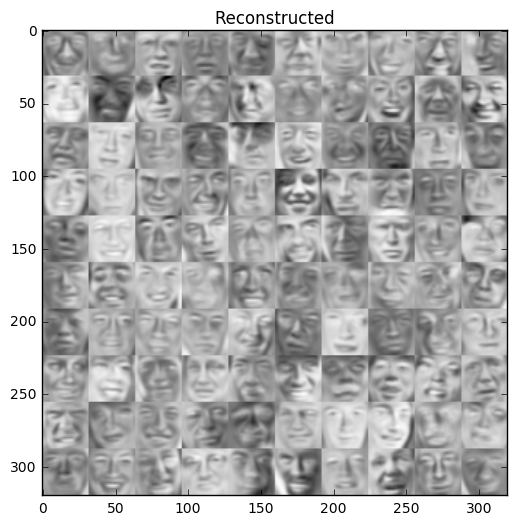

In [376]:
DisplayData(Xfaces)
plt.title('Original')

DisplayData(Xfaces_recovered)
plt.title('Reconstructed')